# Prvi zadatak
Pred tobom je prvi zadatak iz vežbaonice iz mašinskog učenja. Kroz njega ćeš proći neke osnovne koncepte pripreme podataka, obrade slike, kao i par različitih modela klasifikacije. Nadamo se da će ti ovo pomoći da utvrdiš gradivo sa predavanja i primeniš ga na konkretnu problematiku.
    
Sigurno si bar čuo za igru "papir-kamen-makaze". U folderu "Rock Paper Scissors" nalazi se baza podataka sa slikama šake u sva tri različita položaja. Cilj zadatka je projektovati inovativni sistem za prepoznavanje pokazanih znakova (njihovu klasifikaciju). Ispod ćeš pronaći odvojene celine koje predstavljaju korake u standadrdnom pristupu projektovanja jednog sistema primenom mašinskog učenja. Takođe, primetićeš i neka mesta popunjena komentarima; njih je potreno izmeniti tako da se odgovori na očekivani zadatak.

#### Učitavanje potrebnih biblioteka

Pre svega, potrebno je učitati biblioteke potrebne za dalji rad. U sličaju da bilo šta dodatno bude potrebno, možeš dopisati biblioteke ispod.

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2
import os
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# ovde možeš učitati dodatne biblioteke ukoliko za njima bude potrebe

## Analiza i priprema podataka

Hajde da prvo učitamo podatke i pogledadmo šta imamo u našoj bazi.

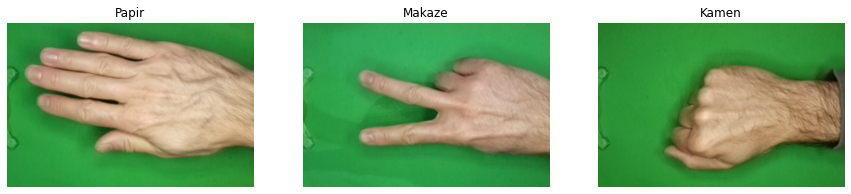

In [5]:
# učitavanje primera slika prosleđenih u okviru foldera
slika_1, slika_2, slika_3 = plt.imread('test1.png'), plt.imread('test2.png'), plt.imread('test3.png') 

# prikaz slika
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(slika_1), plt.axis('off'), plt.title('Papir')
plt.subplot(1, 3, 2)
plt.imshow(slika_2), plt.axis('off'), plt.title('Makaze')
plt.subplot(1, 3, 3)
plt.imshow(slika_3), plt.axis('off'), plt.title('Kamen')
plt.show()

Kao što vidimo, naša baza se sastoji od tri različita položaja šake na zelenoj pozadini.     
Ako se prisetimo predavanja, potrebno je izdvojiti različita karakteristična obeležja iz priloženih slika da bi se nad njima projektovao neki od statističkkih klasifikatora u daljim koracima.

Šta znači izdvojiti neke karakteristike? Hajde razmisli o tome. Šta je ono što moežeš uočiti kao razlike između ove tri slike samo gledajući u njih?
Ja ću navesti dve stvari, a ti dopuni spisak sa još dve nove:     
1. Kod papira ruka prekriva skoro celu pozadinu, kod makaza i kamena manje. 
2. Kod slike papira, svih 5 prstiju je ispruženo, kod makaze dva, kod kamena ni jedan.    
3. <span style="color:red"> dopuniti novom karakteristikom </span>
4. <span style="color:red"> dopuniti novom karakteristikom </span>

Pomenute karakteristike je potrebno kvantifikovati, odnosno predstaviti brojevima. Pre nego što to uradimo, potrebno je pripremiti sliku za izvlačenje tih karakteristika.

## Obrada slike

Pre izdvajanja karakteristika potrebno je obraditi sliku. Kod namenjen za ovu celinu nalazi se u funckiji ispod.  

Koraci predobrade:       
1. Prvo je potrebno zamutiti sliku radi otklanjanja naglih ivica
2. Zatim sledi binarizacija slike - svi pikseli koji imaju bilo kakvu koncentraciju zelene treba da postanu crni, a ostali da postanu beli
3. Primeniti dilataciju kojom su uvećani objekti i uklonjeni mali razmaci između prstiju (dok je šaka zatvorena na primer), kako bi se kasnije izdvojila konzistentna celina 
4. Onda primeniti eroziju kako bi se oblik vratio na prethodne dimenzije

In [29]:
def preprocessing(picture) -> np.ndarray:
    # zamucivanje slike
    picture = cv2.GaussianBlur(picture, (11,11), 0)

    # binarizacija slike po zelenoj boji
    picture = np.where((picture[:,:,0] < 0.5) & (picture[:,:,1] > 0.1) & (picture[:,:,2] < 0.5), 0, 1)
    # konverzija slike u uint8 format
    picture = picture.astype(np.uint8)
    
    # dilatacija slike
    kernel = np.ones((5,5), np.uint8)
    picture = cv2.dilate(picture, kernel, iterations=3)
    # erozija slike
    picture = cv2.erode(picture, kernel, iterations=3)

    return picture

Primer slika nakon procesiranja.

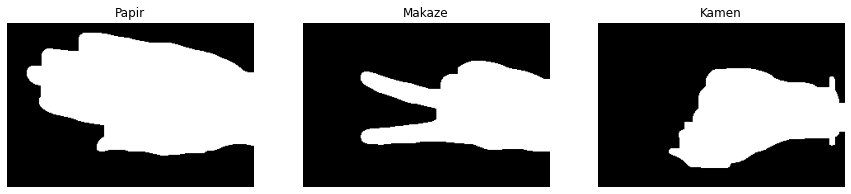

In [30]:
obradjena_slika_1 = preprocessing(slika_1)
obradjena_slika_2 = preprocessing(slika_2)
obradjena_slika_3 = preprocessing(slika_3)

# prikaz obradjenih slika
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(obradjena_slika_1, cmap='gray'), plt.axis('off'), plt.title('Papir')
plt.subplot(1, 3, 2)
plt.imshow(obradjena_slika_2, cmap='gray'), plt.axis('off'), plt.title('Makaze')
plt.subplot(1, 3, 3)
plt.imshow(obradjena_slika_3, cmap='gray'), plt.axis('off'), plt.title('Kamen')
plt.show()

## Izvlačenje karakterističnih obeležja

Sada kada smo dobili binarizovane slike šake, postaje lakše izvući karakteristike. 

Priseti se prve predložene karakteristike koja razlikuje slike šaka koje pokazuju papir kamen i makaze:   
- Kod papira ruka prekriva skoro celu pozadinu, kod makaza i kamena manje.    

Kako bi kvantitativno predstavio ovakvu karakteristiku? Ukoliko je više piksela bele boje na slici, verovatnije je da ta slika predstavlja papir, nego makaze i kamen. Ukoliko uporedimo broj belih piksela na levoj strani slike, videćemo da će se za papir javiti neki, dok će za kamen najverovatnije levi deo slike ostati prazan. Ispod se nalazi par funkcije koje izvljače prvih par karakteristika.

Odnos broja belih i svih piksela na slici (udeo belih piksela u celoj slici):

In [31]:
def feature1(picture) -> int:
    """Vraca udeo belih piksela u slici"""

    return sum(sum(picture)) / (len(picture)*len(picture[:,0]))

Udeo belih piksela u levoj i desnoj polovini slike:

In [32]:
def feature2(picture) -> list:
    """Vraca udeo belih piksela u 2 segmenta slike"""

    len_x, len_y = picture.shape        # duzina i sirina slike
    segment1 = picture[:, :len_y//2]    # levi segment slike
    segment2 = picture[:, len_y//2:]    # desni segment slike

    return [sum(sum(segment1)) / (len(segment1)*len(segment1[:,0])), sum(sum(segment2)) / (len(segment2)*len(segment2[:,0]))]

Funkcija find_features primenjuje sve prethodne i vraća listu svih karakteristika. 

In [36]:
def find_features(path) -> list:
    """Vraca listu svih karakteristika"""

    pic = plt.imread(path)              # ucitavanje slike
    pic_bin = preprocessing(pic)        # obrada slike
    
    features = [feature1(pic_bin)]      # izvlacenje prve karakteristike
    features.extend(feature2(pic_bin))  # izvlacenje druge dve karakteristike

    # ovde dodati sve naknadno izvucene karakteristike

    return features

## Učitavanje i podela podataka na trening i test skup

Pre projektovanja samog klasifikatora jako je bitno pravilno i pravedno podeliti podatke na trening i test skup. Podaci moraju biti potpuno odvojeni i nikako se ne smeju mešati. Primera radi, ako ti nastavnica na testu da iste zadatke koje si radio/la na času, da li si siguran/na da ćeš ispravno naučiti gradivo? Ukoliko provežbaš 100 primera iz sabiranja i 1 primer iz oduzimanja, da li misliš da ćeš sa istom verovatnoćom moći da rešiš i jedan i drugi zadatak? Zato je bitno da nam se i u trening i u test setu nalazi približno isti broj odbiraka iz različitih klasa, kao i da nam kompletan dataset bude balansiran.

In [37]:
def train_test(rock, paper, scissors, perc = 0.8):
    """Podela podataka na trening i test skup"""

    random.shuffle(rock), random.shuffle(paper), random.shuffle(scissors) # mesanje podataka

    rock_train, rock_test = rock[:int(len(rock)*perc)], rock[int(len(rock)*perc):]                          # podela kamena na trening i test skup
    paper_train, paper_test = paper[:int(len(paper)*perc)], paper[int(len(paper)*perc):]                    # podela papira na trening i test skup              
    scissors_train, scissors_test = scissors[:int(len(scissors)*perc)], scissors[int(len(scissors)*perc):]  # podela makaza na trening i test skup

    train_set = rock_train + paper_train + scissors_train   # trening skup
    test_set = rock_test + paper_test + scissors_test       # test skup

    random.shuffle(train_set), random.shuffle(test_set)     # mesanje trening i test skupa

    train_data = np.array([x[0] for x in train_set])        # izdvajanje trening podataka
    train_labels = np.array([x[1] for x in train_set])      # izdvajanje labela za trening
    test_data = np.array([x[0] for x in test_set])          # izdvajanje test podataka
    test_labels = np.array([x[1] for x in test_set])        # izdvajanje labela za test

    return train_data, train_labels, test_data, test_labels

Učitavanje podataka iz baze i enkodovanje labela (kamen - 0, papir - 1, makaze - 2)

In [89]:
rootdir = 'Rock Paper Scissors'                                       # putanja do foldera sa slikama
rock, paper, scissors = [], [], []                                       # liste za kamen, papir i makaze 

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        label = subdir.split('\\')[-1]

        feature = find_features(os.path.join(subdir, file))              # izvlacenje karakteristika slike

        if label == 'rock':
            rock.append([feature, 0])                                    # ukoliko je kamen, labela je 0
        elif label == 'paper':
            paper.append([feature, 1])                                   # ukoliko je papir, labela je 1
        else:
            scissors.append([feature, 2])                                # ukoliko su makaze, labela je 2

## Analiza karakteristika

Nakon što su izdvojene neke karakteristike, hajde da ih malo bolje pogledamo. Koliko su one korisne i koliko su međusobno slične, samo su neka od pitanja koja treba pročešljati pre projektovanja klasifikatora. 

In [110]:
# podela podataka na trening i test skup
train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)

# formiranje dataframe-a za korelacionu analizu karakteristika
df1 = pd.DataFrame(train_data)
df2 = pd.DataFrame(test_data)
df = pd.concat([df1, df2])

# dodavanje labela u dataframe
df['label'] = np.concatenate((train_labels, test_labels))

df # prikaz

,0,1,2,label
0,0.365100,0.148100,0.217000,0
1,0.470125,0.134225,0.335900,2
2,0.438250,0.092650,0.345600,2
3,0.623200,0.261750,0.361450,1
4,0.523625,0.234650,0.288975,1
...,...,...,...,...
422,0.495900,0.145175,0.350725,1
423,0.462900,0.120550,0.342350,2
424,0.339725,0.121325,0.218400,2
425,0.388625,0.063175,0.325450,2


Pogledaj ovaj dataframe. U njemu se nalaze tri različite karakteristike za 427 slika iz baze, kao i odgovarajuće labela za svaku. Kako da znamo da li su ove karakteristike koje su izdvojene dovoljno dobre? Možemo uraditi korelacionu analizu sa labelama.

In [91]:
corr_analysis = abs(df.corr()['label']).sort_values(ascending=False)    # korelacija karakteristika sa labelama
corr_analysis = corr_analysis[corr_analysis.index != 'label']
corr_analysis

2    0.187116
1    0.074716
0    0.048029
Name: label, dtype: float64

Brojevi iznad predstavljau koliko je neka od karakteristika korelisana sa labelama. Vidimo da je najbolja druga, dok je najmanje korelisana prva.    
Osim korelacije karakteristika sa labelama, možemo proveriti i koliko su one uzajamno slične. Tačnije, da li nose iste informacije.

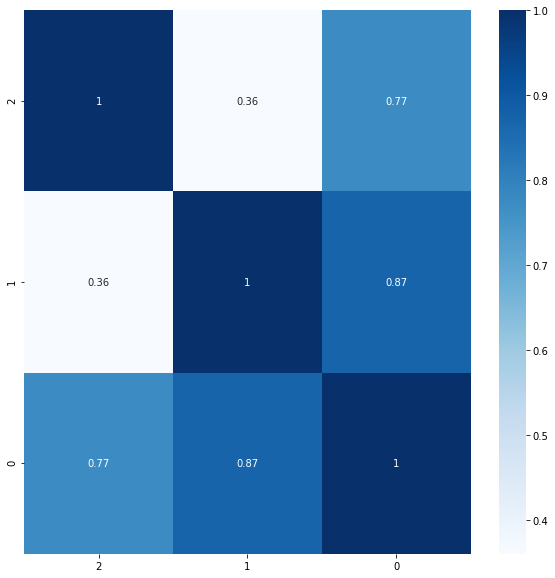

In [92]:
# posmatranje medjusobne korelacije karakteristika
corr = df[corr_indexes].corr()
plt.figure(figsize=(10,10))
sn.heatmap(corr, annot=True, cmap='Blues')
plt.show()

Sa korelacione matrice iznad, možeš videti da je nulta karakteristika jako korelisana i sa prvom i sa drugom, dok su prva i druga karakterisitka međusobno slabije korelisane. Odatle se zaključuje da nulta karakteristika sadrži dosta sličnih informacija sa prvom i drugom karakteristikom, pa možda i nije toliko informativna. Ovu hipotezu ćemo proveriti klasifikacijom.

## Klasifikacija

In [93]:
# prikaz trening podataka
train_data

array([[0.50785 , 0.1201  , 0.38775 ],
       [0.502425, 0.1798  , 0.322625],
       [0.295075, 0.      , 0.295075],
       ...,
       [0.4002  , 0.0479  , 0.3523  ],
       [0.436975, 0.09995 , 0.337025],
       [0.393675, 0.043375, 0.3503  ]])

Iz analize karakteristika, došli smo do zaključka da karakteristike 1 i 2 nose većinu sadržaja prve, tako da je za dalju klasifikaciju možda potrebno koristiti samo njih. Ćeliju ispod izmeniti tako da se uzmu samo prva i druga karakterisika i posmatrati kako se rezultati klasifikacije menjaju.

In [137]:
train_data = train_data[:, 0:]
test_data = test_data[:, 0:]

### KNN (k najbližih suseda)

Prvi klasifikator koji ćeš implementirati je klasifikator K Najbližih Suseda. Ispod se nalazi ilustrativni prikaz njegovog algoritma odlučivanja.
<img src="knn.gif" width="500" height="360"/>




In [142]:
train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(train_data, train_labels)
pred = knn.predict(test_data)
acc = accuracy_score(test_labels, pred)

acc

0.7213114754098361

Prisetimo se pojma krosvalidacije. Šta ona predstavlja?  
<span style="color:red"> Ovde upisati komentar na zadato pitanje. </span>    
Dopuniti ćeliju ispod tako da se čuvaju metrike i matrice konfuzije za 20 različitih foldova, a onda prikazati prosečne i najbolje rezultate.

In [138]:
num_of_folds = 20         # broj ponavljanja
accs, matrices = [], []   # liste za cuvanje tacnosti i matrica konfuzije

for i in range(num_of_folds):
    train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)
    knn = KNeighborsClassifier(n_neighbors=15)
    knn.fit(train_data, train_labels)
    pred = knn.predict(test_data)
    acc = accuracy_score(test_labels, pred)
    conf = confusion_matrix(test_labels, pred)
    
    accs.append(acc)
    matrices.append(conf)

Accuracy:  71.87 %
Standard deviation:  1.32 %
Max accuracy:  74.24 %
Confusion matrix: 


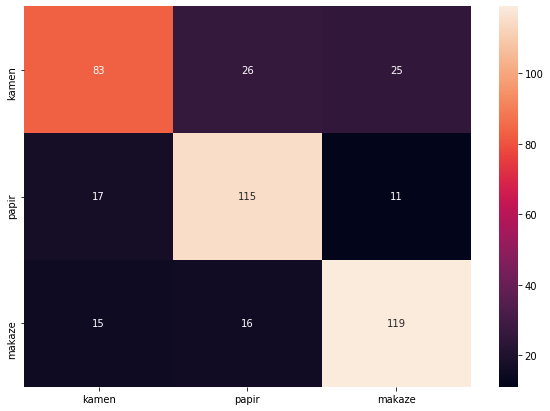

In [139]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['kamen', 'papir', 'makaze']],
                    columns = [i for i in ['kamen', 'papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

Osmotri dobijene brojke. Srednja i maksimalna tačnost se kreću u opsegu 70-75%. Za klasifikaciju tri različite klase, random verovatnoća podotka iznosi 33.33%. U poređenju sa tim, kao i uzimajući u obzir jednostavnost korišćenih karakteristika, može se reći da dati klasifikator dovoljno dobro radi posao.  

### Bajesov test minimalne verovatnoće greške

Ispred tebe se nalazi novi vid klasifikatora. Pokušaj da odgovoriš na sledeće pitanje: Kako se Bajesov test minimalne verovatnoće greške razlikuje od KNN klasifikatora? Pokreni kod ispod i analiziraj rezultate. Da li je on pogodniji za ovu problematiku? Kakva se tačnost dobija?

In [98]:
def testing_hypothesis(train_data, train_labels, test_data, test_labels, chosen_features = corr_indexes): 
    """Metoda testiranja hipoteza"""

    train_data = train_data[:, chosen_features]         # izdvajanje karakteristika koje ce biti koriscene za klasifikaciju
    test_data = test_data[:, chosen_features]           # izdvajanje karakteristika koje ce biti koriscene za klasifikaciju
    
    exp_avg1 = np.mean(train_data[train_labels == 0], axis=0)   # Ek - ovekivanje za kamen
    cov1 = np.cov(train_data[train_labels == 0].T)              # Sk - kovarijaciona matrica za kamen
    exp_avg2 = np.mean(train_data[train_labels == 1], axis=0)   # Ep - ovekivanje za papir
    cov2 = np.cov(train_data[train_labels == 1].T)              # Sp - kovarijaciona matrica za papir
    exp_avg3 = np.mean(train_data[train_labels == 2], axis=0)   # Em - ovekivanje za makaze
    cov3 = np.cov(train_data[train_labels == 2].T)              # Sm - kovarijaciona matrica za makaze

    p1 = len(train_data[train_labels == 0]) / len(train_data)   # verovatnoca kamena 
    p2 = len(train_data[train_labels == 1]) / len(train_data)   # verovatnoca papira
    p3 = len(train_data[train_labels == 2]) / len(train_data)   # verovatnoca makaza

    f1 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov1)) * np.exp(-0.5 * (x - exp_avg1).T @ np.linalg.inv(cov1) @ (x - exp_avg1)) # fgv za kamen
    f2 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov2)) * np.exp(-0.5 * (x - exp_avg2).T @ np.linalg.inv(cov2) @ (x - exp_avg2)) # fgv za papir
    f3 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov3)) * np.exp(-0.5 * (x - exp_avg3).T @ np.linalg.inv(cov3) @ (x - exp_avg3)) # fgv za makaze

    predicted = []  # predvidjene labele
    for x in test_data:     
        if p1*f1(x) > p2*f2(x) and p1*f1(x) > p3*f3(x):     
            predicted.append(0)
        elif p2*f2(x) > p1*f1(x) and p2*f2(x) > p3*f3(x):
            predicted.append(1)
        else:
            predicted.append(2)

    # racunanje tacnosti i matrice konfuzije
    return sum(predicted == test_labels) / len(test_labels), confusion_matrix(test_labels, predicted)

In [144]:
num_of_folds = 20         # broj ponavljanja
accs, matrices = [], []   # liste za cuvanje tacnosti i matrica konfuzije

for i in range(num_of_folds):
    train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)
    acc, conf = testing_hypothesis(train_data, train_labels, test_data, test_labels, chosen_features = [1,2])
    accs.append(acc)
    matrices.append(conf)

Accuracy:  71.39 %
Standard deviation:  1.54 %
Max accuracy:  74.24 %
Confusion matrix: 


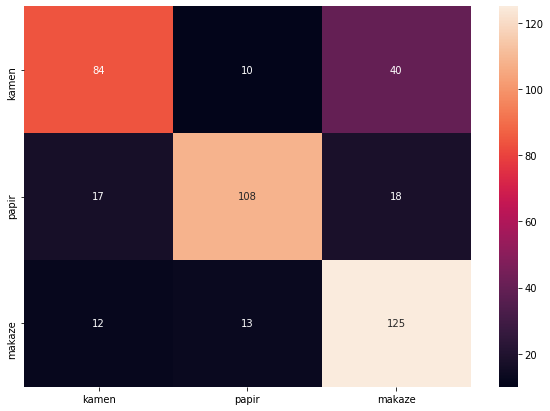

In [145]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['kamen', 'papir', 'makaze']],
                    columns = [i for i in ['kamen', 'papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

Iz korelacione matrice uoči koja se dva položaja šake najmanje mešaju, pa za ta dva elementa prikaži histograme obeležja. Uporediti ih i analiziraj njihove razlike.

Prikaz histograma obeležja 1

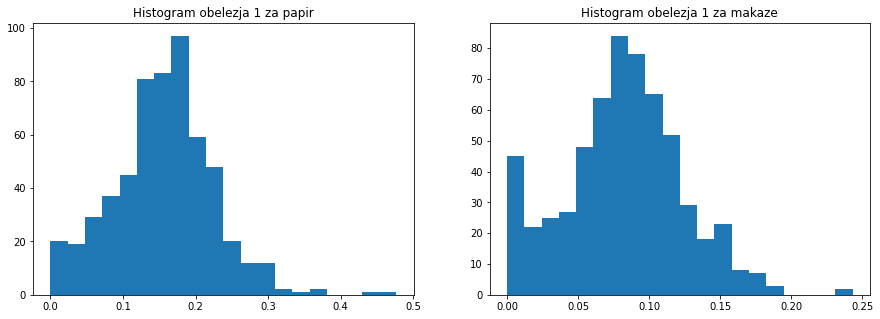

In [146]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data[train_labels == 1][:,1], bins=20)
plt.title('Histogram obelezja 1 za papir')
plt.subplot(1, 2, 2)
plt.hist(train_data[train_labels == 2][:,1], bins=20)
plt.title('Histogram obelezja 1 za makaze')
plt.show()


Prikaz histograma obeležja 2

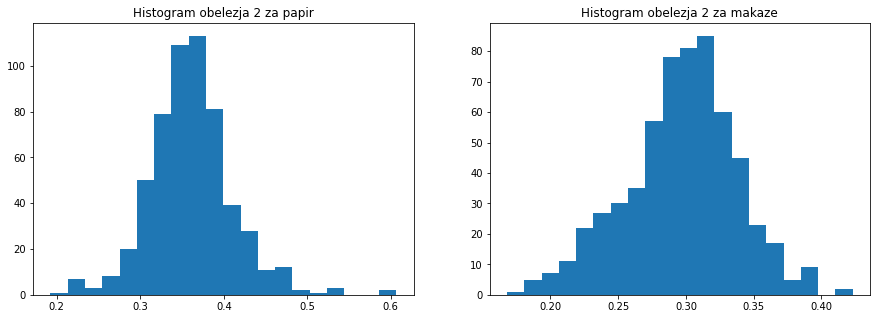

In [147]:
# prikaz histograma obelezja 19
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data[train_labels == 1][:,2], bins=20)
plt.title('Histogram obelezja 2 za papir')
plt.subplot(1, 2, 2)
plt.hist(train_data[train_labels == 2][:,2], bins=20)
plt.title('Histogram obelezja 2 za makaze')
plt.show()

Kako se razlikuju dati histogrami?
- <span style="color:red"> Ovde upisati komentar za prvu karakteristiku. </span>  
- <span style="color:red"> Ovde upisati komentar za drugu karakteristiku. </span>  

### Linearni klasifikator na bazi željenog izlaza

Pred tobom je još jedan vid klasifikatora projektovan za prepoznavanje dva položaja šake. Odluči se za dve konkretne klase koje ćeš posmatrati. 

Ovde se nalazi nova funkcija za podelu podataka na trening i test, jer se sada posmatraju samo dve klase.

In [104]:
# funkcija za formiranje trening i test skupa za binarnu klasifikaciju
def train_test_2(paper, scissors, perc = 0.8):    
    """Podela podataka na trening i test skup"""

    random.shuffle(paper), random.shuffle(scissors) # mesanje podataka

    paper_train, paper_test = paper[:int(len(paper)*perc)], paper[int(len(paper)*perc):]                                      # podela papira na trening i test skup
    scissors_train, scissors_test = scissors[:int(len(scissors)*perc)], scissors[int(len(scissors)*perc):]                    # podela makaza na trening i test skup              

    train_set = paper_train + scissors_train   # trening skup
    test_set = paper_test + scissors_test      # test skup

    random.shuffle(train_set), random.shuffle(test_set)     # mesanje trening i test skupa

    train_data = np.array([x[0] for x in train_set])        # izdvajanje trening podataka
    train_labels = np.array([x[1] for x in train_set])      # izdvajanje labela za trening
    test_data = np.array([x[0] for x in test_set])          # izdvajanje test podataka
    test_labels = np.array([x[1] for x in test_set])        # izdvajanje labela za test

    return train_data, train_labels, test_data, test_labels

Projektovati linearni klasifikator na bazi željenog izlaza pomoću formule sa predavanja:



In [105]:
def linear_classifier(train_data, train_labels, test_data, test_labels):
    """Linearni klasifikator na bazi zeljenog izlaza"""

    train_data = np.concatenate((train_data, np.ones((len(train_data), 1))), axis=1) # dodavanje kolone jedinica
    test_data = np.concatenate((test_data, np.ones((len(test_data), 1))), axis=1)    # dodavanje kolone jedinica

    #change train and test labels to -1 and 1
    train_labels[train_labels == 2] = -1

    W = np.linalg.inv(train_data.T @ train_data) @ train_data.T @ train_labels       # W = (X^T * X)^-1 * X^T * y

    results = test_data @ W                                                          # rezultati klasifikacije

    predicted = np.where(results > 0, 1, 2)                                          # predvidjene labele
    train_labels[train_labels == -1] = 2                                             # vracanje labela na 1 i 2

    # racunanje tacnosti i matrice konfuzije
    return sum(predicted == test_labels) / len(test_labels), confusion_matrix(test_labels, predicted), W
    

Krosvalidacija za 20 foldova i linearni klasifikator.

In [106]:
num_of_folds = 20           # broj ponavljanja
accs, matrices = [], []     # liste za cuvanje tacnosti i matrica konfuzije
chosen_features = [1, 2]    # indeksi obelezja koja ce biti koriscena za klasifikaciju
Ws = []                     # lista za cuvanje tezina
data_for_plotting = []      # lista za cuvanje trening i test skupa

for i in range(num_of_folds):
    trd, trl, ted, tel = train_test_2(paper, scissors)          # podela podataka na trening i test skup

    trd = trd[:, chosen_features]                               # izdvajanje obelezja koja ce biti koriscena za klasifikaciju
    ted = ted[:, chosen_features]                               # izdvajanje obelezja koja ce biti koriscena za klasifikaciju

    acc, conf, W = linear_classifier(trd, trl, ted, tel)        # klasifikacija

    # cuvanje rezultata
    accs.append(acc)                                    
    matrices.append(conf)
    Ws.append(W)
    data_for_plotting.append([trd, trl, ted, tel])

Analiza rezultata:

Accuracy:  82.05 %
Standard deviation:  1.76 %
Max accuracy:  85.67 %
Confusion matrix: 


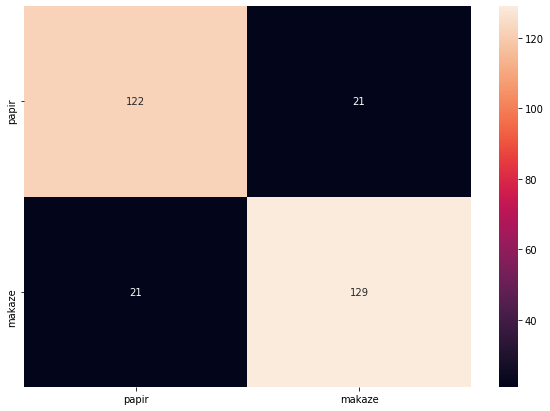

In [107]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['papir', 'makaze']],
                    columns = [i for i in ['papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

Šta se zaključuje iz matrice konfuzije i rezultata klasifikacije? Kakva je tačnost i koje se klase više mešaju? Da li dolazi do preobučavanja, nedovoljnog obučavanja ili je obučavanje regularno? Kako se može popraviti tačnost?

In [108]:
# parametri za prikazivanje (iteracija sa najvecom tacnoscu)
trd = data_for_plotting[max_acc][0]
trl = data_for_plotting[max_acc][1]
ted = data_for_plotting[max_acc][2]
tel = data_for_plotting[max_acc][3]
w_0 = Ws[max_acc][2]
w_1 = Ws[max_acc][1]
w_2 = Ws[max_acc][0]

Plotovanje kriterijumske funkcije u prostoru dva najbolja obeležja.

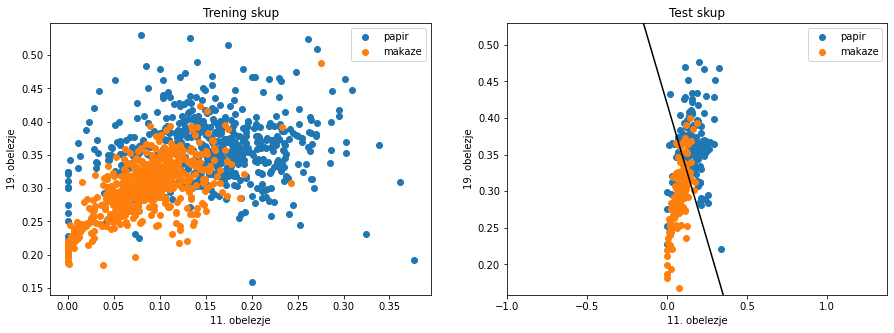

In [109]:
plt.figure(figsize=(15, 5))   

# prikaz odbiraka iz trening skupa
plt.subplot(1, 2, 1)
plt.scatter(trd[trl == 1][:,0], trd[trl == 1][:,1], label='papir')
plt.scatter(trd[trl == 2][:,0], trd[trl == 2][:,1], label='makaze')
plt.title('Trening skup'), plt.xlabel('11. obelezje'), plt.ylabel('19. obelezje'), plt.legend()

# prikaz odbiraka iz test skupa
plt.subplot(1, 2, 2)
plt.scatter(ted[tel == 1][:,0], ted[tel == 1][:,1], label='papir')
plt.scatter(ted[tel == 2][:,0], ted[tel == 2][:,1], label='makaze')
plt.title('Test skup'), plt.xlabel('11. obelezje'), plt.ylabel('19. obelezje'), plt.legend()

# prikaz kriterijumske funkciije
x = np.linspace(min(trd[:,0])-1, max(trd[:,0])+1, 100)
y = (-w_0 - w_2*x)/w_1
plt.plot(x, y, color='black')

# ogranicenja
plt.xlim(min(trd[:,0])-1, max(trd[:,0])+1)
plt.ylim(min(trd[:,1]), max(trd[:,1]))
plt.show();

Da li su ove klase linearno separabile? Koja bi funkcija bila adekvatniji izbor za separacionu krivu?

## Drugi deo zadatka

I još jednom isto pitanje - zamisli da tvoj kupac zeli da poveća tačnost! Kako to možeš uraditi?    
Vrati se naprethodne korake gde si izvlačio/la karakteristike i dodaj još neke za koje misliš da će biti informativnije i korisnije od trenutnih. Ponovo pokreni sve segmente koda i analiziraj rezultate. Šta sada dobijaš? Da li su rezultati bolji i ako da zašto?